In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breakhis/Folds.csv
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/process_db_stat.py
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/fibroadenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/phyllodes_tumor.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/tubular_adenoma.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/adenosis.stat.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/README_B.txt
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Importing all the necessary libraries for image processing
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
os.getcwd()


'/kaggle/working'

In [5]:
#Loading the text file
fold_df = pd.read_csv("../input/breakhis/Folds.csv")

In [6]:
#Defining the paths
img_path = "./BreaKHis_v1/"
classes = ["benign","malign"]

In [7]:
#Renaming the column filename to path
fold_df = fold_df.rename(columns = {"filename":"path"})
#Printing the head of the file
fold_df.head(3)

,fold,mag,grp,path
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [8]:
#One example path is printed
fold_df['path'][1]

'BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png'

In [9]:
#Extracting the filename and label from the path column
fold_df['filename'] = fold_df['path'].apply(lambda x:x.split("/")[-1])
fold_df["label"] = fold_df['path'].apply(lambda x: x.split("/")[3])

In [10]:
#Creating new directory
import os

directory = "../Cancer/"

if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory created successfully")
else:
    print("Directory already exists")

Directory created successfully


In [11]:
#Moving all the images to one folder
for p in fold_df['path']:
    src = "../input/breakhis/BreaKHis_v1/" + p
    dest = "../Cancer/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
    shutil.copyfile(src,dest)  

In [12]:
#Checking the len
len(os.listdir("../Cancer/"))

7909

In [13]:
#Creating a new data frame with labels and file names stored in single folder
fold_df['file_loc'] = fold_df['label'] + "_" + fold_df['filename']
#Encoding the class to integer
fold_df['class'] = fold_df['label'].apply(lambda x: 0 if x =='benign' else 1)

In [14]:
#Printing the head to display the changed made
fold_df.head(3)

,fold,mag,grp,path,filename,label,file_loc,class
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,benign,benign_SOB_B_A-14-22549AB-100-001.png,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,benign,benign_SOB_B_A-14-22549AB-100-002.png,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,benign,benign_SOB_B_A-14-22549AB-100-003.png,0


In [15]:
fold_df= fold_df.drop(['fold', 'mag', 'grp', 'filename'], axis=1)

In [16]:
fold_df.head(-1)

,path,label,file_loc,class
0,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,benign_SOB_B_A-14-22549AB-100-001.png,0
1,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,benign_SOB_B_A-14-22549AB-100-002.png,0
2,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,benign_SOB_B_A-14-22549AB-100-003.png,0
3,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,benign_SOB_B_A-14-22549AB-100-004.png,0
4,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,benign_SOB_B_A-14-22549AB-100-005.png,0
...,...,...,...,...
39539,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,malignant_SOB_M_PC-15-190EF-400-010.png,1
39540,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,malignant_SOB_M_PC-15-190EF-400-011.png,1
39541,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,malignant_SOB_M_PC-15-190EF-400-012.png,1
39542,BreaKHis_v1/histology_slides/breast/malignant/...,malignant,malignant_SOB_M_PC-15-190EF-400-013.png,1


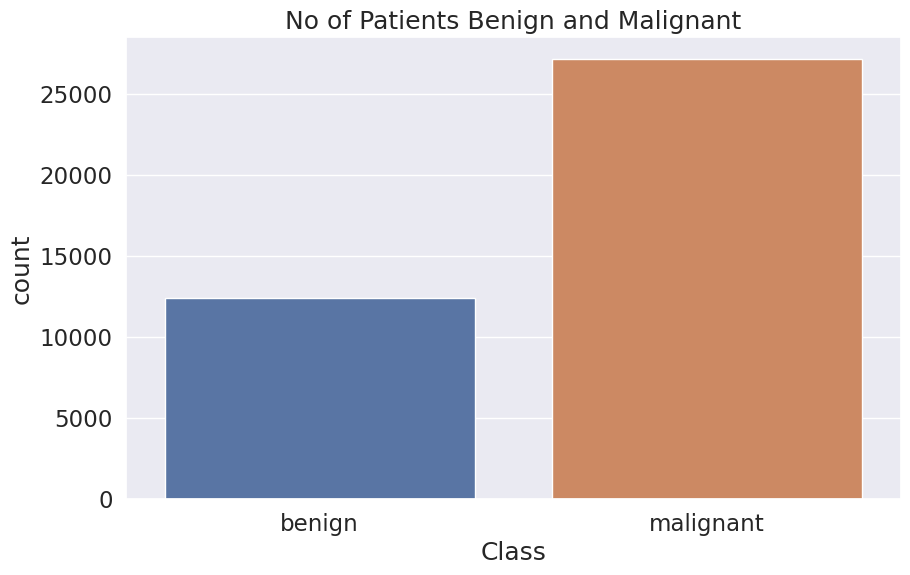

In [17]:
#Lets explore the data set
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.countplot(fold_df, x=fold_df['label']);
plt.xlabel("Class")
plt.title("No of Patients Benign and Malignant");

In [18]:
path = "/kaggle/input/breakhis/BreaKHis_v1/"

img_paths = [] # List of image file paths

# Populate img_paths list with file paths
for i in range(len(fold_df)):
    abs_path = path + fold_df.path[i]
    img_paths.append(abs_path)

In [19]:
print(img_paths[5])

/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-006.png


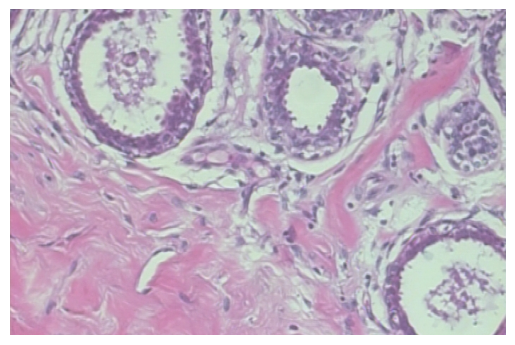

In [20]:
image = cv2.imread(img_paths[2])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Remove axis ticks and labels
plt.show()

In [21]:
import os
import cv2

# Set the directory path containing the input images
input_dir = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB'

# Set the output directory path for the blurred images
output_dir = '/kaggle/working/blured_images'

# Create the output directory if it does not already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the size of the kernel for Gaussian blur
kernel_size = (5, 5)

# Loop over all images in the input directory
for root, dirs, files in os.walk(input_dir):
    for file in files:
        # Load the image
        img_path = os.path.join(root, file)
        img = cv2.imread(img_path)

        # Apply Gaussian blur to the image
        blurred_img = cv2.GaussianBlur(img, kernel_size, 0.5)

        # Save the blurred image to the output directory
        output_path = os.path.join(output_dir, file)
        cv2.imwrite(output_path, blurred_img)

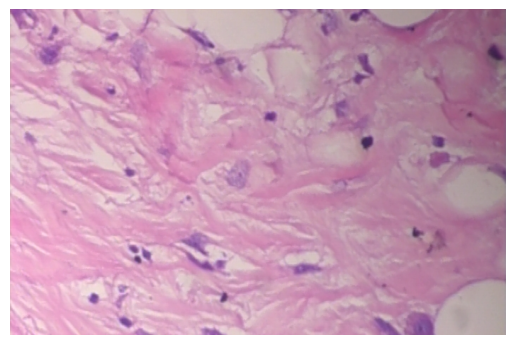

In [22]:
# Get the first image file name
first_image_file = os.listdir(output_dir)[9]

# Load the first image
first_image_path = os.path.join(output_dir, first_image_file)
first_image = cv2.imread(first_image_path)

# Display the original and blurred images side by side
plt.imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Remove axis ticks and labels
plt.show()

In [23]:
# Set the directory path containing the input images
input_dir = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB'

# Set the output directory path for the blurred images
output_dir = '/kaggle/working/blured_images'

# Create the output directory if it does not already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set the size of the kernel for Gaussian blur
kernel_size = (5, 5)

# Loop over all images in the input directory
for root, dirs, files in os.walk(input_dir):
    for file in files:
        # Load the image
        img_path = os.path.join(root, file)
        img = cv2.imread(img_path)

        # Apply Gaussian blur to the image
        blurred_img = cv2.GaussianBlur(img, kernel_size, 0)

        # Save the blurred image to the output directory
        output_path = os.path.join(output_dir, file)
        cv2.imwrite(output_path, blurred_img)

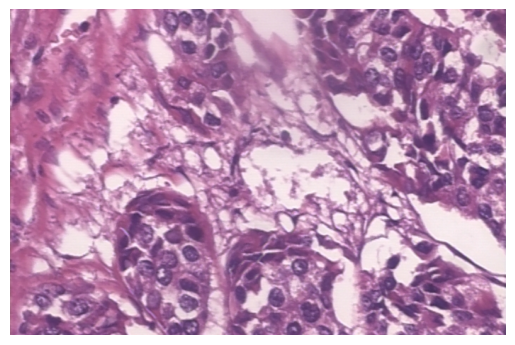

In [24]:
# Get the last image file name
first_image_file = os.listdir(output_dir)[-1]

# Load the first image
first_image_path = os.path.join(output_dir, first_image_file)
first_image = cv2.imread(first_image_path)

# Display the original and blurred images side by side
plt.imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Remove axis ticks and labels
plt.show()

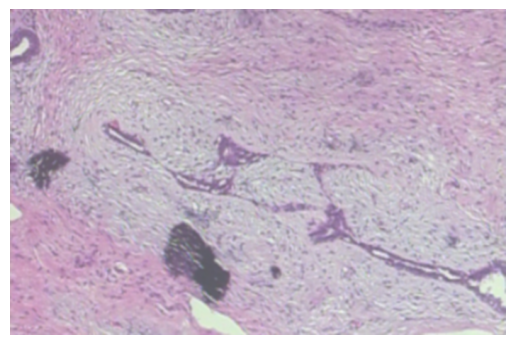

In [25]:
# Get the first image file name
first_image_file = os.listdir(output_dir)[3]

# Load the first image
first_image_path = os.path.join(output_dir, first_image_file)
first_image = cv2.imread(first_image_path)

# Display the original and blurred images side by side
plt.imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Remove axis ticks and labels
plt.show()

In [26]:
#Creating a new data frame with the file loc as its index, label and class of the patients as its columns.
df = pd.DataFrame(os.listdir(output_dir))
df = df.rename(columns = {0:'file_loc'})
df['label'] = df['file_loc'].apply(lambda x:x.split("_")[1])
df['class'] = df['label'].apply(lambda x: 0 if x =='B' else 1)
df.set_index("file_loc",inplace=True)
    

In [27]:
#Checking the data frame
df.head(5)

,label,class
file_loc,,
SOB_B_F-14-14134E-200-004.png,B,0
SOB_B_F-14-23060CD-200-015.png,B,0
SOB_M_DC-14-6241-40-002.png,M,1
SOB_B_PT-14-22704-40-018.png,B,0
SOB_M_DC-14-2523-200-033.png,M,1


import os
from staintools import StainNormalizer
from skimage import io

# Set the directory path containing the input images
input_dir = '/kaggle/working/blured_images'

# Set the output directory path for the blurred images
output_dir = '/kaggle/working/normalized_images'

# Create the output directory if it does not already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create a stain normalizer object
normalizer = StainNormalizer(method='vahadane')

# Loop over all images in the input directory
for root, dirs, files in os.walk(input_dir):
    for file in files:
        # Load the image
        img_path = os.path.join(root, file)
        img = io.imread(img_path)

        # Fit the normalizer to the image
        normalizer.fit(img)
        
        # Apply the normalizer to the image
        normalized_img = normalizer.transform(img)

        # Save the blurred image to the output directory
        output_path = os.path.join(output_dir, file)
        cv2.imwrite(output_path, normalized_img)

In [28]:
#Performing the splitting
data_train_and_val, data_test = train_test_split(df, test_size = 0.2, random_state = 47)
#Traing and val
data_train, data_val = train_test_split(data_train_and_val, test_size = 0.2, random_state = 47)

In [29]:
print("Training size :", data_train.shape)
print("Validation size :", data_val.shape)
print("Testing size :", data_test.shape)

Training size : (5061, 2)
Validation size : (1266, 2)
Testing size : (1582, 2)


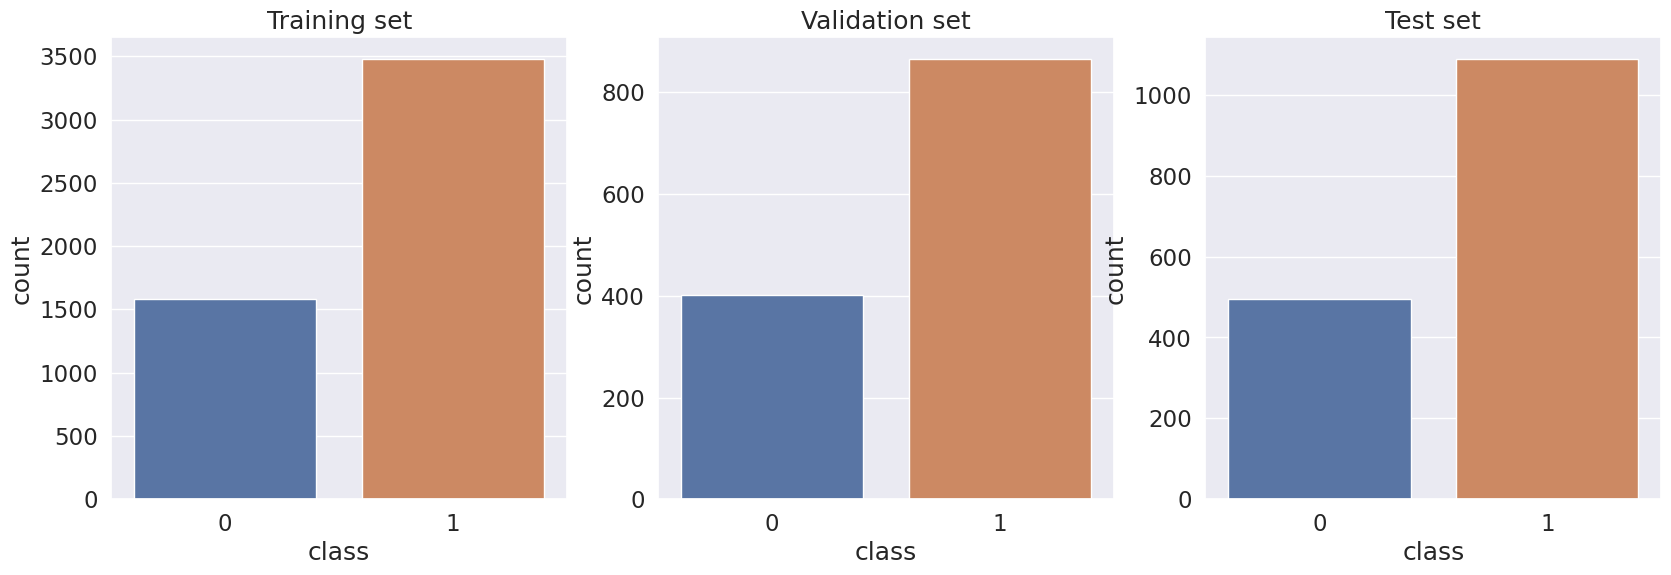

In [30]:
#Plotting
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train, x=data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val, x=data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test, x=data_test['class']);
plt.title("Test set");

In [31]:
#Separating the benign and malignant patients from train data
train_has_cancer = data_train[data_train['class'] == 1]
train_has_no_cancer = data_train[data_train['class'] == 0]

In [32]:
train_has_cancer.shape


(3476, 2)

In [33]:
train_has_no_cancer.shape


(1585, 2)

In [34]:
#Upsampling the minority class by the size of majority class with replacement
train_has_no_cancer_upsample = resample(train_has_no_cancer, n_samples = len(train_has_cancer), 
                                     random_state = 47, replace = True)

In [35]:
#Concatenating the upsampled minority class and the majority class
data_train = pd.concat([train_has_cancer,train_has_no_cancer_upsample])

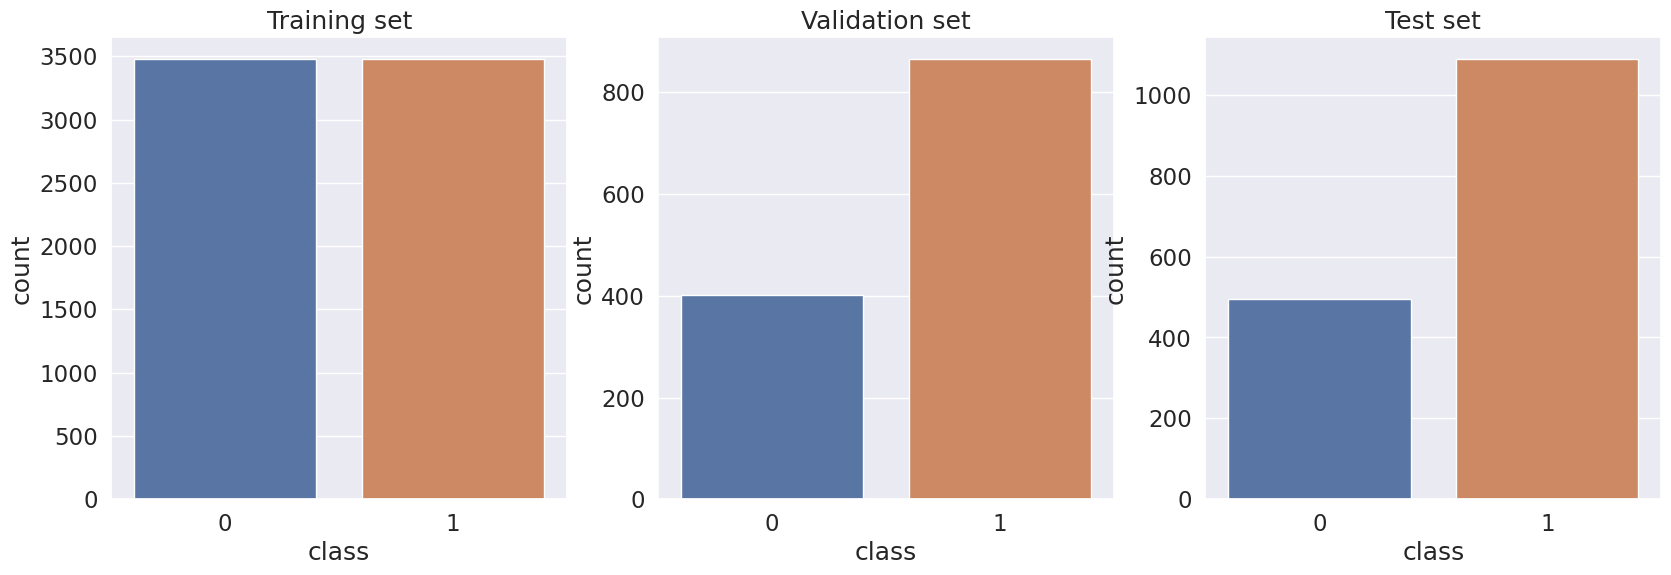

In [36]:
#Plotting after upsampling data_train
sns.set_style("darkgrid")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
sns.countplot(data_train, x=data_train['class'])
plt.title("Training set")
plt.subplot(1,3,2)
sns.countplot(data_val, x=data_val['class'])
plt.title("Validation set")
plt.subplot(1,3,3)
sns.countplot(data_test, x=data_test['class']);
plt.title("Test set");

In [37]:
#Creating the directories to store images
os.makedirs("../Cancer_train")
os.makedirs("../Cancer_test")
os.makedirs("../Cancer_validation")
os.makedirs("../Cancer_train/benign")
os.makedirs("../Cancer_train/malignant")
os.makedirs("../Cancer_validation/benign")
os.makedirs("../Cancer_validation/malignant")
os.makedirs("../Cancer_test/benign")
os.makedirs("../Cancer_test/malignant")

In [38]:
#Training data
i = 1
for img in data_train.index:
    if img!=".DS_Store":
        target = df.loc[img,'class']
        if target == 1:
            label = 'malignant'
        else:          
            label = 'benign'      
        src = os.path.join('/kaggle/working/blured_images',img)
        dest = os.path.join("../Cancer_train/",label, "image" + str(i)+".png")
        img1 = np.array(cv2.imread(src))
        cv2.imwrite(dest,img1)
        i = i+1

In [39]:
#Validation data
for img in data_val.index:
    target = data_val.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join('/kaggle/working/blured_images',img)
    dest = os.path.join("../Cancer_validation/",label,img)
    shutil.copyfile(src,dest)

In [40]:
#Testing data
for img in data_test.index:
    target = data_test.loc[img,'class']
    if target == 1:
        label = 'malignant'
    else:
        label = 'benign'
        
    src = os.path.join('/kaggle/working/blured_images',img)
    dest = os.path.join("../Cancer_test/",label,img)
    shutil.copyfile(src,dest)

In [41]:
#Checking their lengths
print("Training Data:")
print(" ")
print("Benign:",len(os.listdir("../Cancer_train/benign/")))
print("Malignant::",len(os.listdir("../Cancer_train/malignant/")))
print(" ")
print("Validation Data")
print(" ")
print("Benign size:",len(os.listdir("../Cancer_validation/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_validation/malignant/")))
print(" ")
print("Testing Data:")
print(" ")
print("Benign size :",len(os.listdir("../Cancer_test/benign/")))
print("Malignant size :",len(os.listdir("../Cancer_test/malignant/")))

Training Data:
 
Benign: 3476
Malignant:: 3476
 
Validation Data
 
Benign size: 401
Malignant size : 865
 
Testing Data:
 
Benign size : 494
Malignant size : 1088


# Data Augmentation

In [42]:
#Defining Image Data Generator
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2)

In [43]:
#Setting up the images for image data generator
train_generation = datagen.flow_from_directory("../Cancer_train/",target_size=(128,128),batch_size = 32, class_mode="binary")
val_generation = datagen.flow_from_directory("../Cancer_validation/", target_size=(128,128), batch_size=32, class_mode="binary")

Found 6952 images belonging to 2 classes.
Found 1266 images belonging to 2 classes.


In [45]:

#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [47]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

# DenseNet121 Model

In [48]:
# import numpy as np
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Assuming you have already created the train and validation data generators
# train_generation and val_generation

# Step 2: Create the DenseNet121 base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add your custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
cancer_model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Compile the model
cancer_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Step 4: Fit the model using the train and validation data generators
#Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/200
218/218 [==============================] - 243s 988ms/step - loss: 0.4162 - accuracy: 0.8261 - val_loss: 0.3644 - val_accuracy: 0.8444
Epoch 2/200
218/218 [==============================] - 204s 937ms/step - loss: 0.1779 - accuracy: 0.9295 - val_loss: 0.2014 - val_accuracy: 0.9226
Epoch 3/200
218/218 [==============================] - 191s 877ms/step - loss: 0.1401 - accuracy: 0.9478 - val_loss: 0.1822 - val_accuracy: 0.9313
Epoch 4/200
218/218 [==============================] - 188s 863ms/step - loss: 0.1075 - accuracy: 0.9580 - val_loss: 0.0875 - val_accuracy: 0.9637
Epoch 5/200
218/218 [==============================] - 122s 559ms/step - loss: 0.0846 - accuracy: 0.9678 - val_loss: 0.3853 - val_accuracy: 0.8886
Epoch 6/200
218/218 [==============================] - 121s 554ms/step - loss: 0.0748 - accuracy: 0.9754 - val_loss: 0.1356 - val_accuracy: 0.9502
Epoch 7/200
218/218 [==============================] - 123s 563ms/step - loss: 0.0548 - accuracy: 0.9786 - val_loss: 0

In [51]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("../Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)


Found 1582 images belonging to 2 classes.


In [52]:
loss, accuracy = cancer_model.evaluate(test_gen)
print("Accuracy: {:.2f}%".format(accuracy*100))

1582/1582 [==============================] - 45s 27ms/step - loss: 0.1670 - accuracy: 0.9507
Accuracy: 95.07%


In [53]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already created the test data generator
# test_gen

# Get the model's predictions on the test data
y_pred = cancer_model.predict(test_gen)

# Convert predictions from one-hot encoding to class labels (assuming sparse_categorical_crossentropy loss)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the test data generator
y_true = test_gen.classes

# Generate the classification report
report = classification_report(y_true, y_pred_classes)

print("Classification Report:")
print(report)


1582/1582 [==============================] - 37s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       494
           1       0.93      0.99      0.96      1088

    accuracy                           0.94      1582
   macro avg       0.95      0.91      0.93      1582
weighted avg       0.94      0.94      0.94      1582



Confusion Matrix:
[[ 413   81]
 [  10 1078]]


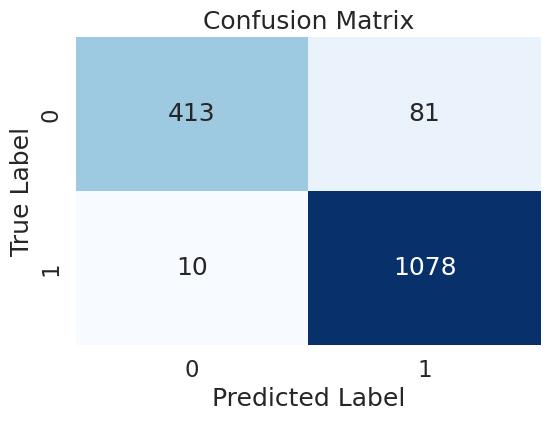

In [55]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# DenseNet201 Model

In [56]:
import numpy as np
from keras.applications import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Assuming you have already created the train and validation data generators
# train_generation and val_generation

# Step 2: Create the DenseNet201 base model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
cancer_model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Compile the model
cancer_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Step 4: Fit the model using the train and validation data generators
# Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200,
                           callbacks=[early_stop, checkpoint], verbose=1)


74836368/74836368 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
218/218 [==============================] - 172s 664ms/step - loss: 0.3006 - accuracy: 0.8721 - val_loss: 0.9322 - val_accuracy: 0.7441
Epoch 2/200
218/218 [==============================] - 129s 591ms/step - loss: 0.1575 - accuracy: 0.9380 - val_loss: 0.1852 - val_accuracy: 0.9392
Epoch 3/200
218/218 [==============================] - 128s 586ms/step - loss: 0.0955 - accuracy: 0.9622 - val_loss: 0.4207 - val_accuracy: 0.8673
Epoch 4/200
218/218 [==============================] - 128s 586ms/step - loss: 0.0690 - accuracy: 0.9751 - val_loss: 0.8020 - val_accuracy: 0.8002
Epoch 5/200
218/218 [==============================] - 127s 584ms/step - loss: 0.0675 - accuracy: 0.9771 - val_loss: 0.1405 - val_accuracy: 0.9542
Epoch 6/200
218/218 [==============================] - 128s 585ms/step - loss: 0.0459 - accuracy: 0.9833 - val_loss: 0.1787 - val_accuracy: 0.9542
Epoch 7/200
218/218 [==============================] - 128s 586ms/step - loss: 0.0647 - accuracy: 0.9777 - val_loss: 0

In [60]:
loss, accuracy = cancer_model.evaluate(test_gen)
print("Accuracy: {:.2f}%".format(accuracy*100))

1582/1582 [==============================] - 48s 30ms/step - loss: 0.0990 - accuracy: 0.9684
Accuracy: 96.84%


In [58]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already created the test data generator
# test_gen

# Get the model's predictions on the test data
y_pred = cancer_model.predict(test_gen)

# Convert predictions from one-hot encoding to class labels (assuming sparse_categorical_crossentropy loss)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the test data generator
y_true = test_gen.classes

# Generate the classification report
report = classification_report(y_true, y_pred_classes)

print("Classification Report:")
print(report)


1582/1582 [==============================] - 50s 30ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       494
           1       0.99      0.97      0.98      1088

    accuracy                           0.97      1582
   macro avg       0.96      0.97      0.96      1582
weighted avg       0.97      0.97      0.97      1582



Confusion Matrix:
[[ 479   15]
 [  38 1050]]


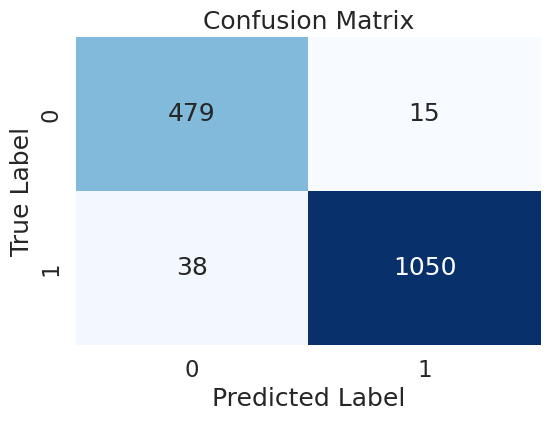

In [59]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# ResNet50 Model

In [63]:

from keras.applications import ResNet50


# Assuming you have already created the train, validation, and test data generators
# train_generation, val_generation, and test_gen

# Step 2: Create the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
cancer_model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Compile the model
cancer_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Step 4: Fit the model using the train and validation data generators
# Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200,
                           callbacks=[early_stop, checkpoint], verbose=1)


94765736/94765736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
218/218 [==============================] - 132s 567ms/step - loss: 0.3565 - accuracy: 0.8566 - val_loss: 0.8865 - val_accuracy: 0.6833
Epoch 2/200
218/218 [==============================] - 119s 546ms/step - loss: 0.1703 - accuracy: 0.9381 - val_loss: 0.6730 - val_accuracy: 0.6833
Epoch 3/200
218/218 [==============================] - 120s 550ms/step - loss: 0.1231 - accuracy: 0.9553 - val_loss: 0.6229 - val_accuracy: 0.6912
Epoch 4/200
218/218 [==============================] - 119s 546ms/step - loss: 0.1008 - accuracy: 0.9625 - val_loss: 1.1916 - val_accuracy: 0.6943
Epoch 5/200
218/218 [==============================] - 119s 547ms/step - loss: 0.1069 - accuracy: 0.9613 - val_loss: 1.6907 - val_accuracy: 0.7314
Epoch 6/200
218/218 [==============================] - 118s 542ms/step - loss: 0.0664 - accuracy: 0.9780 - val_loss: 0.1403 - val_accuracy: 0.9518
Epoch 7/200
218/218 [==============================] - 119s 546ms/step - loss: 0.0662 - accuracy: 0.9767 - val_loss: 0

In [64]:
loss, accuracy = cancer_model.evaluate(test_gen)
print("Accuracy: {:.2f}%".format(accuracy*100))

1582/1582 [==============================] - 34s 21ms/step - loss: 0.0847 - accuracy: 0.9716
Accuracy: 97.16%


In [65]:

# Assuming you have already created the test data generator
# test_gen

# Get the model's predictions on the test data
y_pred = cancer_model.predict(test_gen)

# Convert predictions from one-hot encoding to class labels (assuming sparse_categorical_crossentropy loss)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the test data generator
y_true = test_gen.classes

# Generate the classification report
report = classification_report(y_true, y_pred_classes)

print("Classification Report:")
print(report)

1582/1582 [==============================] - 31s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       494
           1       0.97      0.98      0.98      1088

    accuracy                           0.97      1582
   macro avg       0.97      0.96      0.97      1582
weighted avg       0.97      0.97      0.97      1582



Confusion Matrix:
[[ 466   28]
 [  18 1070]]


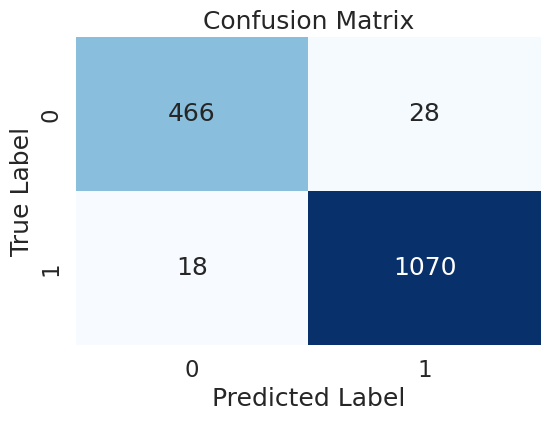

In [66]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# InceptionV3 Model

In [67]:

from keras.applications import InceptionV3


# Assuming you have already created the train, validation, and test data generators
# train_generation, val_generation, and test_gen

# Step 2: Create the InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
cancer_model = Model(inputs=base_model.input, outputs=predictions)

# Step 3: Compile the model
cancer_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Step 4: Fit the model using the train and validation data generators
# Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200,
                           callbacks=[early_stop, checkpoint], verbose=1)


87910968/87910968 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
218/218 [==============================] - 134s 566ms/step - loss: 0.5124 - accuracy: 0.7481 - val_loss: 0.3635 - val_accuracy: 0.8483
Epoch 2/200
218/218 [==============================] - 119s 547ms/step - loss: 0.2632 - accuracy: 0.8892 - val_loss: 0.2472 - val_accuracy: 0.9036
Epoch 3/200
218/218 [==============================] - 118s 543ms/step - loss: 0.1852 - accuracy: 0.9295 - val_loss: 0.2320 - val_accuracy: 0.9281
Epoch 4/200
218/218 [==============================] - 119s 545ms/step - loss: 0.1511 - accuracy: 0.9433 - val_loss: 0.2319 - val_accuracy: 0.9273
Epoch 5/200
218/218 [==============================] - 117s 537ms/step - loss: 0.1199 - accuracy: 0.9561 - val_loss: 0.2150 - val_accuracy: 0.9336
Epoch 6/200
218/218 [==============================] - 119s 544ms/step - loss: 0.1056 - accuracy: 0.9610 - val_loss: 0.1298 - val_accuracy: 0.9502
Epoch 7/200
218/218 [==============================] - 118s 542ms/step - loss: 0.0871 - accuracy: 0.9678 - val_loss: 0

In [68]:
loss, accuracy = cancer_model.evaluate(test_gen)
print("Accuracy: {:.2f}%".format(accuracy*100))

1582/1582 [==============================] - 35s 22ms/step - loss: 0.0823 - accuracy: 0.9798
Accuracy: 97.98%


In [69]:
# Assuming you have already created the test data generator
# test_gen

# Get the model's predictions on the test data
y_pred = cancer_model.predict(test_gen)

# Convert predictions from one-hot encoding to class labels (assuming sparse_categorical_crossentropy loss)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the test data generator
y_true = test_gen.classes

# Generate the classification report
report = classification_report(y_true, y_pred_classes)

print("Classification Report:")
print(report)

1582/1582 [==============================] - 33s 20ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       494
           1       0.99      0.98      0.98      1088

    accuracy                           0.98      1582
   macro avg       0.98      0.98      0.98      1582
weighted avg       0.98      0.98      0.98      1582



Confusion Matrix:
[[ 478   16]
 [  17 1071]]


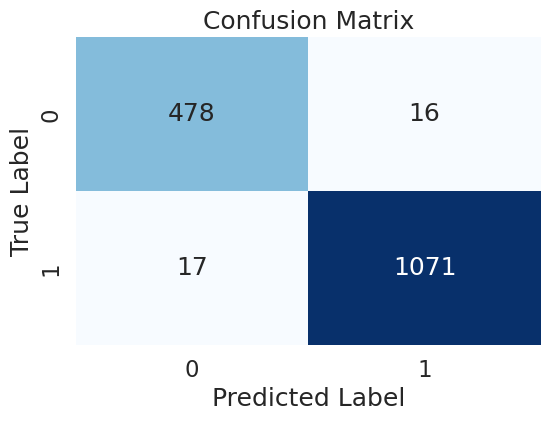

In [70]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# CNN Model

In [71]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (128,128,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_95 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_96 (Conv2D)          (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 128)      0

In [72]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [73]:
#Model is fitted using train and validation generator for 200 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=200 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/200


2023-07-29 19:13:19.704801: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


218/218 [==============================] - 124s 541ms/step - loss: 0.5650 - accuracy: 0.7169 - val_loss: 0.5622 - val_accuracy: 0.7512
Epoch 2/200
218/218 [==============================] - 115s 529ms/step - loss: 0.5149 - accuracy: 0.7690 - val_loss: 0.4785 - val_accuracy: 0.8318
Epoch 3/200
218/218 [==============================] - 114s 523ms/step - loss: 0.4859 - accuracy: 0.7814 - val_loss: 0.4900 - val_accuracy: 0.8246
Epoch 4/200
218/218 [==============================] - 114s 523ms/step - loss: 0.4730 - accuracy: 0.7955 - val_loss: 0.5104 - val_accuracy: 0.8404
Epoch 5/200
218/218 [==============================] - 115s 529ms/step - loss: 0.4430 - accuracy: 0.8162 - val_loss: 0.4465 - val_accuracy: 0.8144
Epoch 6/200
218/218 [==============================] - 114s 522ms/step - loss: 0.4385 - accuracy: 0.8169 - val_loss: 0.4690 - val_accuracy: 0.8341
Epoch 7/200
218/218 [==============================] - 116s 531ms/step - loss: 0.4156 - accuracy: 0.8261 - val_loss: 0.4308 - val_

KeyboardInterrupt: 

In [ ]:
#Model is fitted using train and validation generator for 300 epochs
history = cancer_model.fit(train_generation, validation_data=val_generation, epochs=300 ,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/300
218/218 [==============================] - 114s 524ms/step - loss: 0.3432 - accuracy: 0.8569 - val_loss: 0.4329 - val_accuracy: 0.8254
Epoch 2/300
218/218 [==============================] - 116s 532ms/step - loss: 0.3386 - accuracy: 0.8587 - val_loss: 0.3554 - val_accuracy: 0.8468
Epoch 3/300
218/218 [==============================] - 114s 523ms/step - loss: 0.3159 - accuracy: 0.8700 - val_loss: 0.3077 - val_accuracy: 0.8776
Epoch 4/300
218/218 [==============================] - 116s 532ms/step - loss: 0.3001 - accuracy: 0.8746 - val_loss: 0.2841 - val_accuracy: 0.8776
Epoch 5/300
218/218 [==============================] - 112s 514ms/step - loss: 0.2866 - accuracy: 0.8839 - val_loss: 0.2865 - val_accuracy: 0.8744
Epoch 6/300
218/218 [==============================] - 114s 521ms/step - loss: 0.2737 - accuracy: 0.8878 - val_loss: 0.2787 - val_accuracy: 0.8799
Epoch 7/300
218/218 [==============================] - 114s 523ms/step - loss: 0.2574 - accuracy: 0.8963 - val_loss: 0

In [ ]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluation on Test Data

In [ ]:
#Loading the test data using Image Data Generator
test_gen = datagen.flow_from_directory("../Cancer_test/", target_size=(128,128), class_mode="binary", batch_size=1, shuffle=False)


In [ ]:
pred = cancer_model.evaluate(test_gen)

In [ ]:
#Let's Go ahead and test our model for few Images.

#Array to hold Input Images and their labels
test = []
labels = []

#Loading random 10 images
random_images = np.random.choice(data_test.index,10)

#For loop to read and store images
for i in random_images:
    #Finding their class to load from folder
    label = data_test.loc[i,"class"]
    labels.append(label)
    if label == 1:
        lab = "malignant"
    else:
        lab = "benign"
    #Creating path
    path = os.path.join("../Cancer_test/", lab, i)
    #reading image
    img = cv2.imread(path)
    #resizing to target shape
    img = cv2.resize(img,(128,128))
     #Making it an numpy array
    img = np.array(img)
    #Appending it to the list
    test.append(img)

#Making the list as numpy array
test = np.asarray(test)
#rescaling it by pixel value
test = test/255. 

In [ ]:
#Performing the prediction
pred = (cancer_model.predict(test) > 0.5).astype("int32")
#Flattening the list to form single dimensional list
pred = pred.flatten()

In [ ]:
#Plotting results and actual prediction
plt.figure(figsize=(20,10))
plt.suptitle("Prediction Vs Actual Result")
for i in range(0,10):
    string = "Actual:" + str(labels[i]) + ", Predicted:" + str(pred[i])
    plt.subplot(2,5,i+1)
    plt.imshow(test[i])
    plt.title(string)

# Doing model evaluation to check the performance of the Cnn model

In [ ]:
# Perform predictions on the test set using the model
y_pred_probs = cancer_model.predict(test_gen)
y_pred = np.round(y_pred_probs).astype(int)

In [ ]:
acc = history.history['accuracy']
print(acc)


In [ ]:
# Perform predictions on the test set using the model
y_pred_probs = cancer_model.predict(test_gen)
y_pred = np.round(y_pred_probs).astype(int)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(y_pred_probs, axis=1)

# Assign test labels based on 'class' column in data_test
test_labels = data_test['class'].values

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, predicted_labels, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']

    print(f'{target_name} Precision: {precision:.2f}')
    print(f'{target_name} Recall: {recall:.2f}')
    print(f'{target_name} F1-Score: {f1_score:.2f}')

# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}'.format(avg_precision * 100))
print('Average Recall: {:.2f}'.format(avg_recall * 100))
print('Average F1 Score: {:.2f}'.format(avg_f1_score * 100))

cnn_precision = avg_precision
cnn_recall = avg_recall
cnn_f1score = avg_f1_score

# Calculate and display the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)
